# Capstone Project 1 - Part 4  Machine Learning


# IN PROGRESS ---- 

### Prediction of electricity rates (cost/Kwh) and consumption 
### Author: Elizabeth Izarra

### General Problem:

Electricity has a very dynamic market price since it is a commodity that is essential for daily life and non-storable where generation and demand must be continuously balanced. This is turn make it dependable of the weather conditions. 

### Data Sources:

- U.S. Energy Information Administration (EIA)
- National Oceanic and Atmospheric Administration NOAA

See Capstone Project 1 - Part 1 Data Acquisition and Data Wrangling 

#### File used as source for this Capstone Project 1- Part 4:  
AllData_2.csv  - generated in Capstone Project 1 - Part 1 Data Acquisition and Data Wrangling

### Data Preparation



 From Project1_Part2 can be visualized that the Data is Time Series and non-stationary due to:
 
 1.Trend - the Retail price of Electricy grows over time. The trend component of our predicted variable might be due to inflation or some other macro-economic factors that are not reflected in the collected features into the data. 
 
 2.- Seasonality - there is a periodic change the price which might be considered in some models as sesonality. Nevertheless, It was studied that the Retail price of Electricy tend to be higher in months with higher temperature. Thus, depending on the model these changes can be considered just as a consequece of the correlation with temperature.
 
 

 

### Model Selection

According to the observed in the Project1_Part3 - Statistic Inference, it would be necessary a model per region.  Nevertheless, for the initial model selection,the predicted variable would be the US average temperature in order to simplify complexity and reduce computation time.

Two kind of models were considered: Time-series univariable models and multivariable models




#### Moving Average

<img src="img_part4/moving_average_model.png">

<img src="img_part4/moving_average_cv.png">

#### Facebook Prophet (fbprophet) also known as Prophet

Prophet is a univariate model. It could be considered a naive model since it intends to predict the outcome based just on the dates (time series).  The model descompount the outcome/response variable 𝑌  behavior into trend and seasonality parts. 

Y =Xi(1) Trend + Xi(2) Seasonality


The trend estimator uses linear regression with changing points as hyperparameter. It was used 'autoscale' which is the default hyperparameter was used.

Seasonalities are estimated using a partial Fourier sum, which is a well known mathematic method traditionally used to model periodic electrical signals. The parameter fourier_order=5 was used. This values was selected by inspection of the graphs of the components since in Project 1_part2 was visualized the dependency of variation of price with respect month of the year due to temperatures. Also, an additive annual seasonality of 365 days was added based on the data analysis done in previous parts.

Reference: https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html

<img src="img_part4/fbprophet_model_part1.png">

<img src="img_part4/fbprophet_model_part2.png">

<img src="img_part4/fbprophet_cv.png">

According to the cross-validation of fbprophet model graph above, the error increases when the test size or prediction window (Horizon) is bigger

In [ ]:
#### ARIMA (autoregressive integrated moving average)

In [ ]:
An ARIMA(0,1,0) model (or I(1) model) is given by X t   = X t − 1   + ε t     {\displaystyle X_{t}=X_{t-1}+\varepsilon _{t}}  X_{t}=X_{t-1}+\varepsilon _{t} — which is simply a random walk.
An ARIMA(0,1,0) with a constant, given by X t   = c + X t − 1   + ε t     {\displaystyle X_{t}=c+X_{t-1}+\varepsilon _{t}}  X_{t}=c+X_{t-1}+\varepsilon _{t} — which is a random walk with drift.
An ARIMA(0,0,0) model is a white noise model.
An ARIMA(0,1,2) model is a Damped Holt's model.
An ARIMA(0,1,1) model without constant is a basic exponential smoothing model.
An ARIMA(0,2,2) model is given by X t   = 2 X t − 1   − X t − 2   + ( α + β − 2 ) ε t − 1   + ( 1 − α ) ε t − 2   + ε t     {\displaystyle X_{t}=2X_{t-1}-X_{t-2}+(\alpha +\beta -2)\varepsilon _{t-1}+(1-\alpha )\varepsilon _{t-2}+\varepsilon _{t}}  {\displaystyle X_{t}=2X_{t-1}-X_{t-2}+(\alpha +\beta -2)\varepsilon _{t-1}+(1-\alpha )\varepsilon _{t-2}+\varepsilon _{t}} — which is equivalent to Holt's linear method with additive errors, or double exponential smoothing.



#### Moving Average + Other regressors

The intention is to remove the trend part (inflation and other macro-ecomic factors) by using moving average and predict the remaining part (which depends on temperature, net generation, consumption, etc) by using different regressors. Thus, the predicted value would be the addition of both predictions. 

In this part, the moving average is calculated to estimate the trend and substract it from the outcome/response variable 𝑌 in order to eliminate the growing trend. 
The new  outcome/response variable 𝑌 without trend will then be estimated 

#### Long Short-Term Memory (LSTM) 
LSTM is a recurrent neural networks able to almost seamlessly model problems with multiple input variables.

### Model Selection Metrics

MSE



### -------------------------------------------------------------------------------------------------------------------------------------------------------

#### Importing relevant modules and defiing functions

In [1]:
# import the relevant modules
import pandas as pd
%matplotlib inline
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import TimeSeriesSplit 
import warnings


warnings.filterwarnings('default') #print the first occurrence of matching warnings for each location where the warning is issued


In [2]:
#Annual and monthly mean in US
def resample_mean_US(df, f='Y'):
   
    df['date']=pd.to_datetime(df['date'], format="%Y-%m-%d")
    if f=='m': 
        df['month']=df['date'].dt.month
    df=df.set_index(['date'])
    df = df.sort_values(by=['date'],ascending=[True])
    df=df.resample(f).mean()
    df.reset_index()
    return df

### Getting Data retrieved in Project_Part1: Data acquisition and data wrangling

In [3]:
#Getting Data retrieved in Project_Part1
file='AllData_2.csv'
df_data_orig=pd.read_csv(file)
df_data_all=df_data_orig.copy()
#delete any unnamed column product of saving DataFrames in range index to csv
df_data_all.drop(df_data_all.columns[df_data_all.columns.str.contains('unnamed',case = False)],axis = 1, inplace=True)
df_data_all.head()

#getting US regions
file='regions.csv'
df_reg_orig=pd.read_csv(file)
df_reg=df_reg_orig.copy()

#Add column Region to the DataFrame
for reg in df_reg.columns:
    #getting the data for the states of New England
    states=df_reg[reg].dropna()
    list_states=list(states.values)

    idx_region=df_data_all.index[df_data_all['state'].isin(list_states)]
    df_data_all.loc[idx_region,'region']=reg

df_data_all['date']=pd.to_datetime(df_data_all['date'], format="%Y-%m-%d")

In [4]:
df_data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 17 columns):
date                                        11016 non-null datetime64[ns]
iso3166                                     11016 non-null object
Net generation                              11016 non-null float64
unit_x                                      11016 non-null object
Retail sales of electricity                 11016 non-null float64
unit_y                                      11016 non-null object
Revenue from retail sales of electricity    11015 non-null float64
unit_x.1                                    11016 non-null object
Average retail price of electricity         11016 non-null float64
unit_y.1                                    11016 non-null object
Number of customer accounts                 7078 non-null float64
unit                                        6732 non-null object
TAVG                                        11016 non-null float64
TMAX                 

In [5]:
df_data_all.head()

,date,iso3166,Net generation,unit_x,Retail sales of electricity,unit_y,Revenue from retail sales of electricity,unit_x.1,Average retail price of electricity,unit_y.1,Number of customer accounts,unit,TAVG,TMAX,TMIN,state,region
0,2018-12-01,USA-AK,508.48364,thousand megawatthours,541.79201,million kilowatthours,107.60184,million dollars,19.86,cents per kilowatthour,344957.0,number of customers,13.919636,19.644565,8.191273,Alaska,Pacific Noncontiguous
1,2018-11-01,USA-AK,459.47404,thousand megawatthours,507.34973,million kilowatthours,97.41503,million dollars,19.20,cents per kilowatthour,345444.0,number of customers,22.048986,27.529054,16.563514,Alaska,Pacific Noncontiguous
2,2018-10-01,USA-AK,437.14615,thousand megawatthours,472.18412,million kilowatthours,94.89770,million dollars,20.10,cents per kilowatthour,346050.0,number of customers,36.289632,43.016667,29.612667,Alaska,Pacific Noncontiguous
3,2018-09-01,USA-AK,566.15276,thousand megawatthours,466.33372,million kilowatthours,90.49571,million dollars,19.41,cents per kilowatthour,345366.0,number of customers,46.673422,55.364026,37.996678,Alaska,Pacific Noncontiguous
4,2018-08-01,USA-AK,636.60150,thousand megawatthours,471.08394,million kilowatthours,93.52328,million dollars,19.85,cents per kilowatthour,345757.0,number of customers,51.921967,58.719016,45.120328,Alaska,Pacific Noncontiguous


# ===============================================

### Working for a model for the US mean temperature

In [6]:
#Aggregating data per month for USA
df=df_data_all.copy()
df_monthly_US=resample_mean_US(df,f='m')
df_monthly_US=df_monthly_US.reset_index()

In [7]:
df_monthly_US.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 10 columns):
date                                        216 non-null datetime64[ns]
Net generation                              216 non-null float64
Retail sales of electricity                 216 non-null float64
Revenue from retail sales of electricity    216 non-null float64
Average retail price of electricity         216 non-null float64
Number of customer accounts                 139 non-null float64
TAVG                                        216 non-null float64
TMAX                                        216 non-null float64
TMIN                                        216 non-null float64
month                                       216 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 17.0 KB


In [8]:
#Fill missing values


In [9]:
#Performance metrics
df_model_assesment=pd.DataFrame(columns=['Model', 'rmsloge', 'rmse','cv_rmse_mean'])

### Moving Average


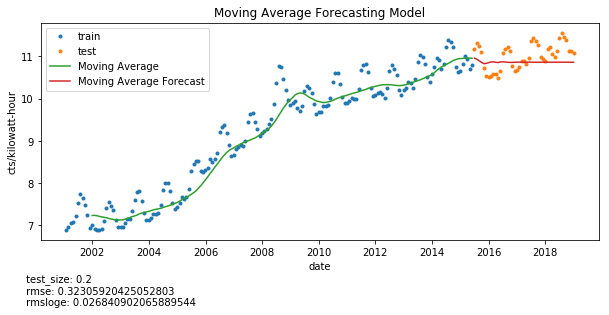

rmse:  0.32305920425052803
rmsloge:  0.026840902065889544


In [10]:
variable='Average retail price of electricity'
df_data=df_monthly_US.copy()
df_train=pd.DataFrame()
df_test=pd.DataFrame()
window=12
test_size=0.2

#Spliting for train (history) and test (future) for trend prediction
max_idx_train=round(len(df_data)*(1-test_size))
df_train=df_data.iloc[0:max_idx_train,slice(None)].set_index('date')
df_test=df_data.iloc[max_idx_train:,slice(None)].set_index('date')

#Getting Variables of interest for moving average (trend estimation)
ts_y_train=df_train[variable]
ts_y_test=df_test[variable]

history=ts_y_train.copy()
ts_y_hat_avg=ts_y_test.copy()

#'fit the model'
ts_moving_avg=ts_y_train.rolling(window).mean()

#predict
for i in ts_y_hat_avg.index :
    ts_y_hat_avg.loc[i]=history.rolling(window).mean().iloc[-1]
    history.loc[i]=ts_y_hat_avg.loc[i]
    
#Model assesment
#Taking the square root of mean_squared_log_error
mslogerror=np.sqrt(mean_squared_log_error( ts_y_test.values, ts_y_hat_avg)) 
#Taking the square root of mean_squared_error
mserror=np.sqrt(mean_squared_error(ts_y_test.values, ts_y_hat_avg))     
   
#Plotting data
#Format the size of the figure/plot
width=10
height=4
plt.rcParams['figure.figsize'] = [width, height]

plt.plot(ts_y_train, marker='.', linestyle='none', label='train')
plt.plot(ts_y_test, marker='.', linestyle='none', label='test') #figsize=(15,8), title= variable, fontsize=14
plt.plot(ts_moving_avg, label='Moving Average')
plt.plot(ts_y_hat_avg, label='Moving Average Forecast')
plt.ylabel('cts/kilowatt-hour')
plt.xlabel('date')

plt.legend(loc='best')
plt.title('Moving Average Forecasting Model')
plt.figtext(0.1, -0.1, 
            ' test_size: '+str(test_size)+
            '\n rmse: ' + str(mserror)+
            '\n rmsloge: ' + str(mslogerror), 
            horizontalalignment='left',
            fontsize=10) 
plt.savefig('img_part4/moving_average_model.png', bbox_inches = "tight")
plt.show()
plt.rcdefaults() #restore plot default values


print('rmse: ', mserror)
print( 'rmsloge: ',mslogerror)

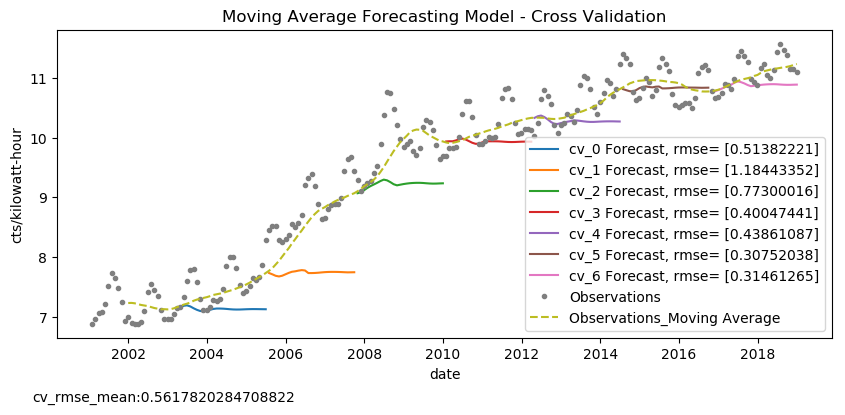

cv_rmse.mean():  0.5617820284708822


In [11]:
#Cross Validation
df_data=df_monthly_US.copy()
df_train=pd.DataFrame()
df_test=pd.DataFrame()
idx_cv=0

n_splits=7
window=12

cv=np.empty(shape=(n_splits,1)) #cross_validation performance metric array


#Data split
tscv = TimeSeriesSplit(n_splits)


#Format the size of the figure/plot
width=10
height=4
plt.rcParams['figure.figsize'] = [width, height]

for train_index, test_index in tscv.split(df_data.index):

        
    df_train=df_data.iloc[train_index,slice(None)].set_index('date')
    df_test=df_data.iloc[test_index,slice(None)].set_index('date')
  
    #Getting Variables of interest for moving average (trend estimation)
    ts_y_train=df_train[variable]
    ts_y_test=df_test[variable]

 
    history=ts_y_train.copy()
    ts_y_hat_avg=ts_y_test.copy()


    #'fit the model'
    ts_moving_avg=ts_y_train.rolling(window).mean()

    #predict
    for i in ts_y_hat_avg.index :
        ts_y_hat_avg.loc[i]=history.rolling(window).mean().iloc[-1]
        history.loc[i]=ts_y_hat_avg.loc[i]

    
    #Model assesment
    #Taking the square root of mean_squared_log_error
    mslogerror=np.sqrt(mean_squared_log_error( ts_y_test.values, ts_y_hat_avg)) 
    #Taking the square root of mean_squared_error
    mserror=np.sqrt(mean_squared_error(ts_y_test.values, ts_y_hat_avg)) 
    
    
    cv[idx_cv]=mserror
          
    #Plotting cross_validation moving average forecast
    plt.plot(ts_y_hat_avg, label=( 'cv_'+str(idx_cv)+ ' Forecast, rmse= '+str(cv[idx_cv])))

    idx_cv+=1


#Plotting data
plt.plot(ts_y_train.append(ts_y_test), marker='.', linestyle='none', label='Observations')
plt.plot(ts_y_train.append(ts_y_test).rolling(window).mean(), label='Observations_Moving Average', linestyle='dashed')
plt.xlabel('date')
plt.ylabel('cts/kilowatt-hour')
plt.legend(loc='best', fontsize=10)
plt.title('Moving Average Forecasting Model - Cross Validation')
plt.figtext(0.1, -0.05, 
            'cv_rmse_mean:'+str(cv.mean()), 
            horizontalalignment='left',
            fontsize=10) 
plt.savefig('img_part4/moving_average_cv.png', bbox_inches = "tight")
plt.show()
plt.rcdefaults() #restore plot default values

print('cv_rmse.mean(): ',cv.mean())


In [12]:

#saving results for later model selection
df_model_assesment=df_model_assesment.append({'Model':'Moving Average',
                                              'rmsloge': mslogerror,
                                              'rmse': mserror,
                                              'cv_rmse_mean':cv.mean()}, 
                                             ignore_index=True)


print(df_model_assesment )



            Model   rmsloge      rmse  cv_rmse_mean
0  Moving Average  0.025935  0.314613      0.561782


### Facebook Prophet (fbprophet) Model

In [13]:
from fbprophet import Prophet  #import facebook prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric 

In [14]:
#Extracting and labeling the time series as required by fbprophet model
df_data=df_monthly_US.copy()
variables=['date', "Average retail price of electricity"]
df_y=df_data.loc[slice(None),variables]
df_y.columns=['ds','y'] #prophet model requires the columns to be label as ds and y

#Spliting for train (history) and test (future)
test_size=0.2
max_idx_train=round(len(df_y)*(1-test_size))
df_y_train=df_y.iloc[0:max_idx_train,slice(None)]
df_y_test=df_y.iloc[max_idx_train:,slice(None)]

#Instantiate
m = Prophet() 
m.add_seasonality(name='yearly', period=365, fourier_order=5, mode='additive') #Parameters

#fit the model
m.fit(df_y_train)


INFO:fbprophet:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Elizabeth\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [15]:
#predict
y_predict = m.predict(df_y_test) 
print(y_predict[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

#Model assesment
#Taking the square root of mean_squared_log_error
mslogerror=np.sqrt(mean_squared_log_error(df_y_test['y'], y_predict['yhat'])) 
#Taking the square root of mean_squared_error
mserror=np.sqrt(mean_squared_error(df_y_test['y'], y_predict['yhat'])) 

print('mslogerror', mslogerror)
print('mserror', mserror)

           ds       yhat  yhat_lower  yhat_upper
38 2018-08-31  12.319658   11.857071   12.784507
39 2018-09-30  12.152319   11.663922   12.632273
40 2018-10-31  11.839232   11.386310   12.345465
41 2018-11-30  11.699975   11.222510   12.225025
42 2018-12-31  11.725543   11.234016   12.244966
mslogerror 0.04641876087501963
mserror 0.5737011447405002


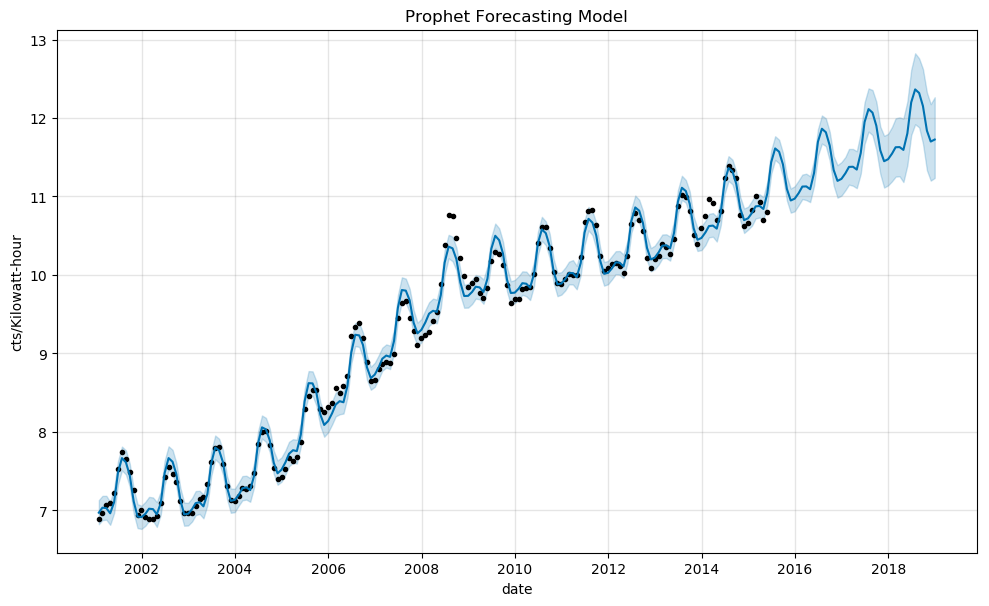

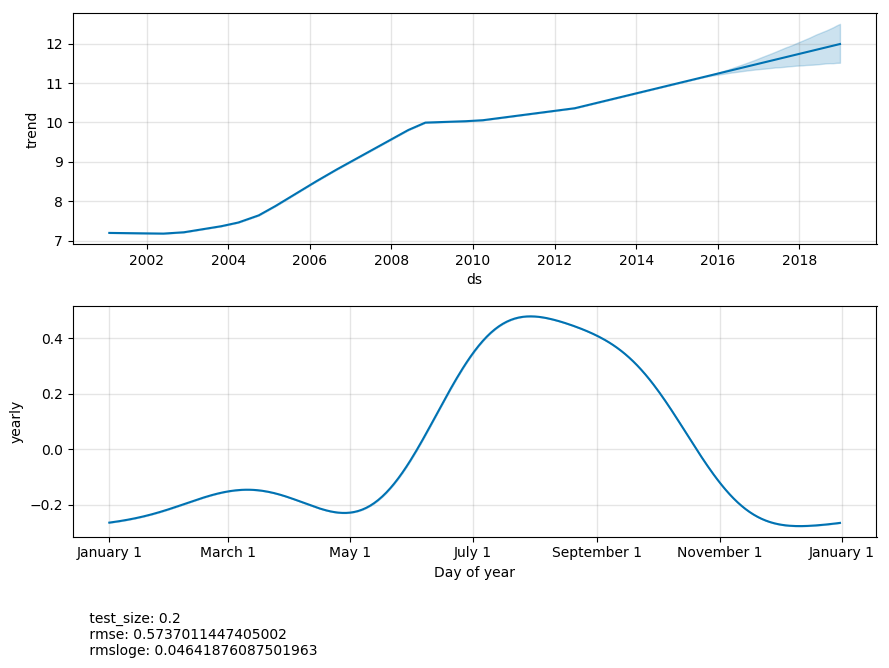

In [16]:
#Visualization of the model

#In this case the prediction is done over the whole data to visualize the model behavior
y_predict_all = m.predict(df_y) 

fig1 = m.plot(y_predict_all)
plt.title('Prophet Forecasting Model')
plt.xlabel('date')
plt.ylabel('cts/Kilowatt-hour')
plt.savefig('img_part4/fbprophet_model_part1.png', bbox_inches = "tight")

fig2 = m.plot_components(y_predict_all)

plt.figtext(0.1, -0.1, 
            ' test_size: '+str(test_size)+
            '\n rmse: ' + str(mserror)+
            '\n rmsloge: ' + str(mslogerror), 
            horizontalalignment='left',
            fontsize=10) 


plt.savefig('img_part4/fbprophet_model_part2.png', bbox_inches = "tight")
plt.show()

INFO:fbprophet:Making 5 forecasts with cutoffs between 2004-06-04 00:00:00 and 2014-05-31 00:00:00
C:\Users\Elizabeth\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



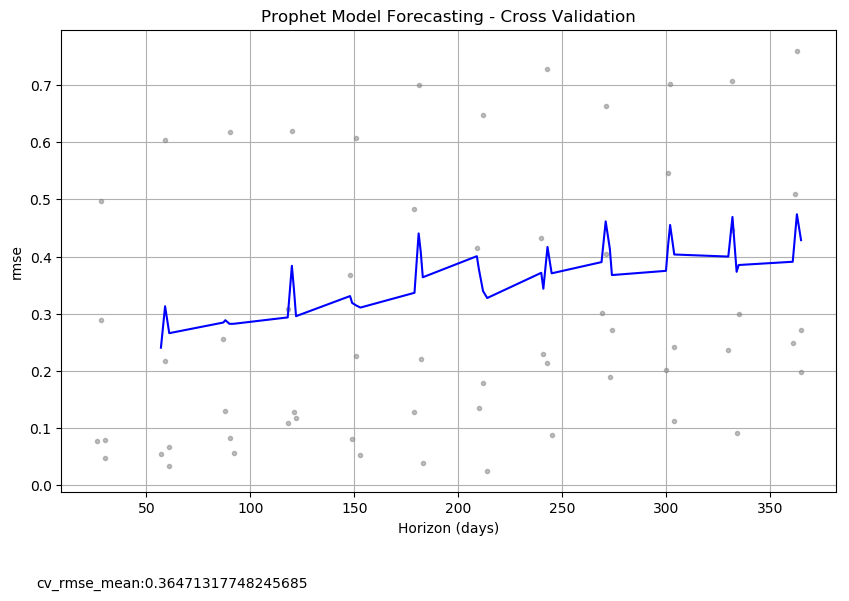

cv_rmse.mean():  0.36471317748245685


In [17]:
#Cross validation

df_cv = cross_validation(m, initial='912 days', period='912 days', horizon = '365 days')
df_p = performance_metrics(df_cv)

fig = plot_cross_validation_metric(df_cv, metric='rmse') 
plt.title('Prophet Model Forecasting - Cross Validation')
plt.figtext(0.1, -0.05, 
            'cv_rmse_mean:'+str(df_p['rmse'].mean()), 
            horizontalalignment='left',
            fontsize=10) 

plt.savefig('img_part4/fbprophet_cv.png', bbox_inches = "tight")
plt.show()


print('cv_rmse.mean(): ',df_p['rmse'].mean())

According to te RMSE graph, the error increase when the test size or prediction window (Horizon) is bigger

In [18]:

#saving results for later model selection
df_model_assesment=df_model_assesment.append({'Model':'fbprophet',
                                              'rmsloge': mslogerror,
                                              'rmse': mserror,
                                              'cv_rmse_mean':df_p['rmse'].mean()}, 
                                             ignore_index=True)


print(df_model_assesment )

            Model   rmsloge      rmse  cv_rmse_mean
0  Moving Average  0.025935  0.314613      0.561782
1       fbprophet  0.046419  0.573701      0.364713


#### ARIMA

In [15]:
#import
from statsmodels.tsa.arima_model import ARIMA 


In [11]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order, test_size, plot=False):
    #Spliting for train (history) and test (future) 
    train_size = int(len(X) * (1-test_size))
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # Model assesment
    rmse = np.sqrt(mean_squared_error(test, predictions))
    rmsloge = np.sqrt(mean_squared_log_error(test, predictions))
    
    if plot:
        #Plotting data
        #Format the size of the figure/plot
        width=10
        height=4
        plt.rcParams['figure.figsize'] = [width, height]

        plt.plot(train, marker='.', linestyle='none', label='train')
        plt.plot(test, marker='.', linestyle='none', label='test') #figsize=(15,8), title= variable, fontsize=14
        plt.plot(predictions, label='ARIMA Forecast')
        plt.ylabel('cts/kilowatt-hour')
        plt.xlabel('date')

        plt.legend(loc='best')
        plt.title('ARIMA Forecasting Model')
        plt.legend()
        plt.figtext(0.1, -0.1, 
                    ' test_size: '+str(test_size)+
                    '\n rmse: ' + str(mserror)+
                    '\n rmsloge: ' + str(mslogerror), 
                    horizontalalignment='left',
                    fontsize=10) 
        plt.savefig('img_part4/arima_model.png', bbox_inches = "tight")
        plt.show()
        plt.rcdefaults() #restore plot default values

    
    
    
    
    return rmse, rmsloge

In [12]:
#grid searching of ARIMA hyperparameters p, d and q 
def grid_searching_ARIMA(dataset, p_values, d_values, q_values, test_size):
    dataset = dataset.astype('float32')
    scores={}
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse, rmsloge = evaluate_arima_model(dataset, order, test_size)
                    scores={order: [rmse, rmsloge]}

                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    return scores 
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [13]:
# evaluate parameters to find best model fit
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 2)
q_values = range(0, 2)


variable='Average retail price of electricity'
df_data=df_monthly_US.copy()
test_size=0.2
grid_searching_ARIMA(df_data[variable].values, p_values, d_values, q_values, test_size)

C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interprete

ARIMA(0, 0, 0) MSE=1.690


C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


ARIMA(0, 0, 1) MSE=0.878


C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interprete

ARIMA(0, 1, 0) MSE=0.179
ARIMA(0, 1, 1) MSE=0.154


C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interprete

ARIMA(0, 2, 0) MSE=0.195
ARIMA(0, 2, 1) MSE=0.198


C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Elizabeth\Anaconda3\li

ARIMA(0, 2, 2) MSE=0.155


C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interprete

ARIMA(1, 0, 0) MSE=0.179
ARIMA(1, 0, 1) MSE=0.154
ARIMA(1, 0, 2) MSE=0.159


C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interprete

ARIMA(1, 1, 0) MSE=0.165
ARIMA(1, 1, 1) MSE=0.158
ARIMA(1, 1, 2) MSE=0.150


C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interprete

ARIMA(1, 2, 0) MSE=0.198


C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(1, 2, 2) MSE=0.159


C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interprete

ARIMA(2, 0, 0) MSE=0.166
ARIMA(2, 0, 1) MSE=0.159
ARIMA(2, 0, 2) MSE=0.160


C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interprete

ARIMA(2, 1, 0) MSE=0.154
ARIMA(2, 1, 1) MSE=0.146
ARIMA(2, 1, 2) MSE=0.147


C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interprete

ARIMA(2, 2, 0) MSE=0.188


C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\Elizabeth\Anaconda3\lib\site-packages\sci

ARIMA(4, 0, 0) MSE=0.154


C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

ARIMA(4, 0, 1) MSE=0.148


C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

ARIMA(4, 0, 2) MSE=0.135


C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interprete

ARIMA(4, 1, 0) MSE=0.153
ARIMA(4, 1, 1) MSE=0.147


C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interprete

ARIMA(4, 2, 0) MSE=0.171
ARIMA(4, 2, 1) MSE=0.154


C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(6, 0, 0) MSE=0.153


C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

ARIMA(6, 0, 1) MSE=0.150


C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarn

ARIMA(6, 1, 0) MSE=0.151
ARIMA(6, 1, 1) MSE=0.138


C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 1, 2) MSE=0.116


C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interprete

ARIMA(6, 2, 0) MSE=0.173


C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`

ARIMA(8, 0, 0) MSE=0.146


C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(8, 0, 1) MSE=0.137


C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`

ARIMA(8, 1, 0) MSE=0.134
ARIMA(8, 1, 1) MSE=0.132


C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`

ARIMA(8, 2, 0) MSE=0.175


C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Elizabeth\Anaconda3\lib\

ARIMA(8, 2, 2) MSE=0.119


C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\Elizabeth\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interprete

ARIMA(10, 0, 0) MSE=0.135


C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Elizabeth\Anaconda3\lib\site-packag

ARIMA(10, 1, 0) MSE=0.131
ARIMA(10, 1, 1) MSE=0.127


C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\Elizabeth\Anaconda3\lib\

ARIMA(10, 2, 0) MSE=0.139


C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(10, 2, 1) MSE=0.113


C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\Elizabeth\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


{(10, 2, 1): [0.11328936623320501, 0.009354389967330661]}
Best ARIMA(10, 2, 1) MSE=0.113


In [ ]:
#Cross_validation

### Moving Average + other Regressors

In [ ]:
#Eliminating the trend component of our predicted variable by substracting the trend from the time series.
ts_diff_y_train=ts_y_train-ts_moving_avg
ts_diff_y_test=ts_y_test-ts_y_hat_avg

df_data.loc[ts_diff_y_train.index,'diff_y']=ts_diff_y_train
df_data.loc[ts_diff_y_test.index, 'diff_y']=ts_diff_y_test

plt.plot(df_data['diff_y'])
plt.plot(ts_diff_y_train, color='red')
plt.plot(ts_diff_y_test, color='blue')
plt.title('US Average retail price of electricity -  without trend')
plt.ylabel('cts per Killowatt-hour')
plt.show()

df_data=df_data.reset_index(drop=True)
df_data=df_data.dropna()

In [ ]:
# Create arrays for the features and the response variable
# Create arrays for the features and the response variable
variable="diff_y"
y = df_data[variable].values
X = df_data.iloc[slice(None),[1,2,3,4,5,8,9]].copy()



In [ ]:
#Linear Regresion
from sklearn.linear_model import LinearRegression

#Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Create the regressor: reg_all
reg_all = LinearRegression()

# Fit the regressor to the training data
reg_all.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)


In [ ]:
# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))

In [ ]:
#Cross Validation
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg_all,X,y, cv=5)

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel('True values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression')
plt.show()

In [ ]:



idx=df_data['date'==ts_diff_y_test.index].index
df_data_test=df_data.loc[idx,slice(None)]

y_test = df_test[variable].values
X_test = df_test.iloc[slice(None),[1,2,3,4,5,8,9]].copy()
y_pred = reg_all.predict(X_test)

In [ ]:
df_data.h

In [ ]:
df_model_assesment

In [ ]:
moving_avg[-12:]

In [ ]:
plt.plot(df_data[variable], color='blue', label='Original', marker='.', linestyle='none')
plt.plot(moving_avg, color='red', label='Rolling Mean')
plt.plot()
#plt.plot(yhat, color='red', label='ARMA')
#plt.plot(df_y_train['date'],moving_std, color='green', label='Rolling Std')
plt.title('Average retail price of electricity - USA')
plt.ylabel('cts per Killowatt-hour')
plt.legend()
plt.show()

In [ ]:
#Eliminating the trend component of our predicted variable
df_monthly_US['price_without_trend']=df_monthly_US['Average retail price of electricity']-moving_avg
plt.plot(df_monthly_US['date'],df_monthly_US['price_without_trend'], color='red')
plt.title('US Average retail price of electricity -  without trend')
plt.ylabel('cts per Killowatt-hour')
plt.show()

In [ ]:
df_monthly_US=df_monthly_US.dropna()
df_monthly_US['Electricity Overhead']=df_monthly_US['Net generation']-df_monthly_US['Retail sales of electricity']
df_monthly_US.info()

In [ ]:
from statsmodels.tsa.arima_model import ARMA

In [ ]:
# list of ml models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import SGDRegressor

def get_models(models=dict()):
# linear models
    models['lr'] = LinearRegression()
    models['lasso'] = Lasso()
    models['ridge'] = Ridge()
    models['en'] = ElasticNet()
    models['huber'] = HuberRegressor()
    models['lars'] = Lars()
    models['llars'] = LassoLars()
    models['pa'] = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
    models['ranscac'] = RANSACRegressor()
    models['sgd'] = SGDRegressor(max_iter=1000, tol=1e-3)
    print('Defined %d models' % len(models))
    return models

In [ ]:
#feature selection
# Instantiate a lasso regressor: lasso
lasso = Lasso(alpha=0.4, normalize=True)

# Fit the regressor to the data
lasso.fit(X_train, y_train)

# Compute and print the coefficients
lasso_coef = lasso.coef_
print(lasso_coef)

df_columns=df_data2.drop(variable, axis=1).columns
# Plot the coefficients
plt.plot(range(len(df_columns)), lasso_coef)
plt.xticks(range(len(df_columns)), df_columns.values, rotation=90)
plt.title('coeficients - '+variable)
plt.margins(0.02)
plt.show()

In [ ]:
df_columns

In [ ]:
from sklearn.model_selection import TimeSeriesSplit 

In [ ]:
####Checking shape
print('X.shape=',X.shape,'y.shape=',y.shape)

In [ ]:
# Reshape X and y
#y = y.reshape(-1,1)
X = X.reshape(-1,1)
print('X.shape=',X.shape,'y.shape=',y.shape)

In [ ]:
from sklearn.model_selection import TimeSeriesSplitimport 
tscv = TimeSeriesSplit(n_splits=5)
TimeSeriesSplit(n_splits=’warn’, max_train_size=None)

#### Scikit-Learn Estimator Selection

In [ ]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

from sklearn.metrics import make_scorer
root_mean_squared_log_error = make_scorer(rmsle, greater_is_better=False)

from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)

In [ ]:
from sklearn.linear_model import LinearRegression  # step 1 - import
lr = LinearRegression()                            # step 2 - instantiate
lr.fit(X, y)                                       # step 3 - fit

lr.score(X, y)
cross_val_score(lr, X, y, cv=kf, scoring=root_mean_squared_log_error)